#### In this notebook, features are created and selected for scaling. These are the features that will be the input of a predictive model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_parquet("../data/processed/cleaned_clv_data.parquet")

In [2]:
df.head()

,customer_id,transaction_count,promo_usage_count,quantity,avg_order_value,first_purchase_date,last_purchase_date,purchase_recency,customer_tenure,payment_method_count,future_spend,total_spent
0,21644,1,1,4,58.543,2021-01-01 01:14:00,2021-01-01 01:14:00,364.948454,364.948454,1,0.0,58.543
1,73192,1,2,2,37.015,2021-01-01 09:21:00,2021-01-01 09:21:00,364.610004,364.610004,1,0.0,74.030
2,9779,1,0,1,4.094,2021-01-01 16:04:00,2021-01-01 16:04:00,364.330234,364.330234,1,0.0,4.094
3,98867,1,0,1,14.923,2021-01-02 01:37:00,2021-01-02 01:37:00,363.932382,363.932382,1,0.0,14.923
4,48935,1,0,2,17.514,2021-01-02 09:29:00,2021-01-02 09:29:00,363.604602,363.604602,1,0.0,35.029


__We'll take transaction recency only in days, it's easier for our model__

__So we'll do the distribution of future spend values(log transformed to remove outlier effect while keeping 0 spend customers)__

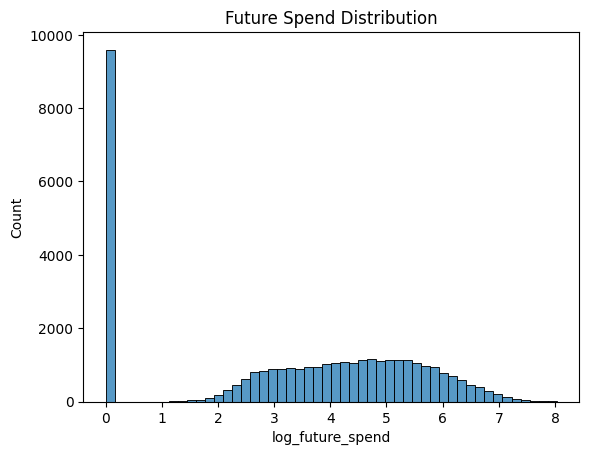

In [3]:
df["log_future_spend"] = np.log1p(df["future_spend"])

plt.figure()
sns.histplot(df["log_future_spend"], bins=50)
plt.title("Future Spend Distribution")
plt.show()

__Grouping buyers and non-buyers based on average transaction activity__
+ Future buyers are more active for promo deals and spend/buy more items
+ Average Gap in purchase recency is about 100 days

In [4]:
df["will_spend"] = (df["future_spend"] > 0 ).astype(int)

df.groupby("will_spend")[[
    "transaction_count",
    "total_spent",
    "avg_order_value",
    "purchase_recency",
    "customer_tenure",
    "promo_usage_count"
]].mean()

,transaction_count,total_spent,avg_order_value,purchase_recency,customer_tenure,promo_usage_count
will_spend,,,,,,
0,1.281322,135.372706,34.662405,147.227677,212.488900,0.695643
1,8.789257,916.456833,49.059931,44.065657,280.433519,4.651329


On average:
+ future spenders make about 8x more transactions
+ And have more recent orders (like 100 days more recent) than those that didn't spend later on

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_usage_count     36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   avg_order_value       36086 non-null  float64       
 5   first_purchase_date   36086 non-null  datetime64[ns]
 6   last_purchase_date    36086 non-null  datetime64[ns]
 7   purchase_recency      36086 non-null  float64       
 8   customer_tenure       36086 non-null  float64       
 9   payment_method_count  36086 non-null  int64         
 10  future_spend          36086 non-null  float64       
 11  total_spent           36086 non-null  float64       
 12  log_future_spend      36086 non-null  float64       
 13  will_spend      

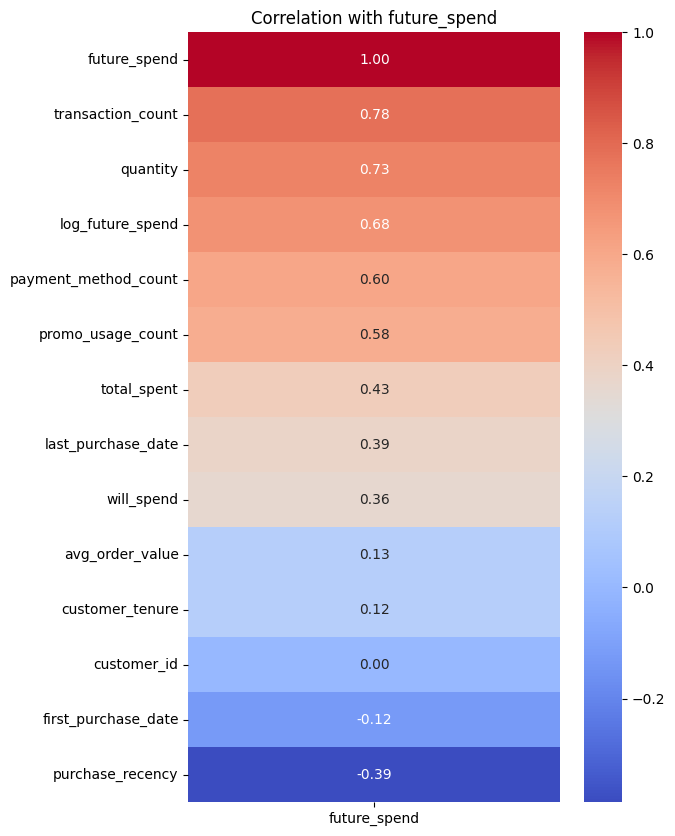

In [6]:

plt.figure(figsize=(6, 10))
sns.heatmap(df.corr()[['future_spend']].sort_values(by='future_spend', ascending=False), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with future_spend')
plt.show()

__We'll keep the features that our model will be making use of an drop everything else__
+ Target variable = `future_spend`
+ Input variable is everything else that will be fed into the model

In [7]:
df.columns

Index(['customer_id', 'transaction_count', 'promo_usage_count', 'quantity',
       'avg_order_value', 'first_purchase_date', 'last_purchase_date',
       'purchase_recency', 'customer_tenure', 'payment_method_count',
       'future_spend', 'total_spent', 'log_future_spend', 'will_spend'],
      dtype='object')

In [8]:
df = df[["last_purchase_date", "purchase_recency", "transaction_count", "quantity", 
        "payment_method_count", "promo_usage_count", "customer_tenure", "total_spent", "future_spend"]]

df.head()

,last_purchase_date,purchase_recency,transaction_count,quantity,payment_method_count,promo_usage_count,customer_tenure,total_spent,future_spend
0,2021-01-01 01:14:00,364.948454,1,4,1,1,364.948454,58.543,0.0
1,2021-01-01 09:21:00,364.610004,1,2,1,2,364.610004,74.030,0.0
2,2021-01-01 16:04:00,364.330234,1,1,1,0,364.330234,4.094,0.0
3,2021-01-02 01:37:00,363.932382,1,1,1,0,363.932382,14.923,0.0
4,2021-01-02 09:29:00,363.604602,1,2,1,0,363.604602,35.029,0.0


In [9]:
df.to_parquet("../data/processed/model_features.parquet", index=False)